# Proyecto Final Señales y Sistemas 2025 -2

## **Objetivo**: Implementar técnicas de representación en tiempo y frecuencia para el reconocimiento de señales de electroencefalografía (EEG) en tareas de imaginación motora (Motor Imagery)


![eegMI](https://figures.semanticscholar.org/288a54f091264377eccc99a19079c9387d66a78f/3-Figure2-1.png)

Las señales de EEG pueden ser ruidosas debido a diversas fuentes, incluidos artefactos fisiológicos e interferencias electromagnéticas. También pueden variar de persona a persona, lo que dificulta la extracción de características y la comprensión de las señales. Además, esta variabilidad, influenciada por factores genéticos y cognitivos, presenta desafíos para el desarrollo de soluciones independientes del sujeto. 

**Base de datos**: GiGaScience Database [https://gigadb.org/dataset/100295](https://gigadb.org/dataset/100295)

Ver Sección 3.1 en [Multimodal Explainability Using Class Activation Maps and Canonical Correlation for MI-EEG Deep Learning Classification](https://www.mdpi.com/2076-3417/14/23/11208)



## 2.1 Estudiar el siguiente cuaderno de Python y realizar los ejercicios all´ı propuestos: Proyecto Final Giga-Science EEGMI GCPDS

# Instalamos las librerias necesarias

# Ejercicio 1
Consultar para qué sirven las siguientes librerías

In [1]:
#!pip install tensorflow==2.15.0
!pip install mne==1.6.0
!pip install braindecode===0.7
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases

#R ------>

#1. TensorFlow 2.15.0
#Es una librería de deep learning de Google.
#Con ella puedo construir, entrenar y evaluar redes neuronales profundas. 
#En este proyecto me sirve para crear modelos que aprendan patrones en las señales, 
#por ejemplo para clasificar EEG o detectar diferentes estados a partir de los datos.

#2. MNE 1.6.0
#MNE es una librería especializada en el manejo de señales neurofisiológicas, sobre todo EEG, MEG y ECoG.
#Me permite:
#Cargar archivos de EEG en diferentes formatos.
#Filtrar, limpiar y preprocesar las señales.
#Marcar eventos, hacer promedios y visualizar los registros en el tiempo y en el espacio (canales, mapas de calor, etc.).

#3. Braindecode 0.7
#Braindecode es una librería de deep learning pensada específicamente para EEG.
#Combina PyTorch/TensorFlow con arquitecturas ya diseñadas para EEG (CNNs, modelos de clasificación, etc.).
#Me sirve para:
#Definir modelos ya optimizados para señales cerebrales.
#Entrenar y evaluar clasificadores de EEG de forma más sencilla que partiendo desde cero.

#4. python-gcpds.databases
#Es un paquete desarrollado por el grupo UN-GCPDS que facilita el acceso a bases de datos usadas en los cursos y proyectos (por ejemplo, bases de EEG y otras señales).
#Con esta librería puedo:
#Descargar y cargar directamente las bases de datos desde Python.
#Tener los datos ya organizados para trabajar con MNE, Braindecode o TensorFlow.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 66.5 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: mne
    Found existing installation: mne 1.9.0
    Uninstalling mne-1.9.0:
      Successfully uninstalled mne-1.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 4.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 13.4 MB/s eta 0:00:00
  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-9uzwaiui
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-9uzwaiui
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit d174df9958b6638156dcfe03996a6307e631a6a2
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=32972807 sha256=707e3a0dda90c4815d51c23b2edfe100b52e30278b46df5041e159b85fb1e45d
  Stored in directory: /tmp/pip-ephem-wheel-cache-e1hiegl

## Importamos algunas librerias necesarias

In [2]:
from scipy.signal import resample
#scipy.signal es un subpaquete de SciPy, una librería fundamental de Python para cálculos científicos y numéricos. 
#Este subpaquete se enfoca en el procesamiento de señales, incluyendo transformadas, filtrados, resampling (cambio de tasa de muestreo), entre otros.

#resample: Utilizada para cambiar la frecuencia de muestreo de una señal. 
#Permite ajustar la cantidad de puntos en una señal, por ejemplo, para convertirla a una tasa de muestreo más alta o más baja.


from scipy.signal import freqz, filtfilt, resample
#freqz: Calcula y devuelve la respuesta en frecuencia de un filtro digital. 
#Esta función es útil para visualizar cómo un filtro afecta a las diferentes frecuencias de la señal.

#filtfilt: Realiza un filtrado bidireccional de una señal, lo que significa que pasa la señal por el filtro en ambas direcciones. 
#Esto ayuda a minimizar el desfase que algunos filtros pueden introducir.


from scipy.signal import butter as bw
#butter (alias bw):Crea los coeficientes de un filtro Butterworth, que es un tipo de filtro de respuesta plana en la banda pasante.

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
from gcpds.databases import GIGA_MI_ME
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones necesarias para el preprocesamiento leve de los datos

In [3]:
def load_GIGA(db,
              sbj,
              eeg_ch_names,
              new_fs,
              fs,
              f_bank=None,
              vwt=None,           
              run=None):

    index_eeg_chs = db.format_channels_selectors(channels = eeg_ch_names) - 1

    #tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)

    db.load_subject(sbj)
    if run == None:
        X, y = db.get_data(classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    else:
        X, y = db.get_run(run, classes = ['left hand mi', 'right hand mi']) #Load MI classes, all channels {EEG}, reject bad trials, uV
    X = X[:, index_eeg_chs, :] #spatial rearrangement
    #X = np.squeeze(tf_repr.transform(X))
    #Resampling
    if new_fs == fs:
        pass#print('No resampling, since new sampling rate same.')
    else:
        print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)

    return X, y

def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

#plot eeg   
def plot_eeg(X,tv,ax,channels,esp=2,title=None):
    # X in CH x Samples
    n_canales = X.shape[0]

    for ch in range(n_canales): # canales
            xx = X[ch]
            xx = xx - np.mean(xx)
            xx = xx/np.max(abs(xx))
            ax.plot(tv, xx +(ch * esp), label=channels[ch])  # Desplazamos cada canal para visualización
    ax.set_yticks(range(0, esp * n_canales, esp), channels)  # Etiquetas en el eje Y
    ax.set_xlabel("Tiempo [s]")
    ax.set_ylabel("Canales EEG [$\mu$V]")
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlim([min(tv)-0.01,max(tv)+0.01])
    ax.set_ylim([-esp,n_canales*esp+0.01])





      

## Establecemos el protocolo de pruebas y la configuración del montaje EEG

Describir el protocolo de captura de datos y el montaje utilizado


![mi](https://www.mdpi.com/diagnostics/diagnostics-13-01122/article_deploy/html/images/diagnostics-13-01122-g001.png)
![montaje](https://www.mdpi.com/applsci/applsci-14-11208/article_deploy/html/images/applsci-14-11208-g001.png)

In [4]:
channels = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']

areas = {
    'Frontal': ['Fpz', 'AFz', 'Fz', 'FCz'],
    'Frontal Right': ['Fp2','AF4','AF8','F2','F4','F6','F8',],
    'Central Right': ['FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8',],
    'Posterior Right': ['P2','P4','P6','P8','P10','PO4','PO8','O2',],
    #'Central': ['Cz'],
    'Posterior': ['CPz','Pz', 'Cz','POz','Oz','Iz',],
    'Posterior Left': ['P1','P3','P5','P7','P9','PO3','PO7','O1',],
    'Central Left': ['FC1','FC3','FC5','FT7','C1','C3','C5','T7','CP1','CP3','CP5','TP7',],
    'Frontal Left': ['Fp1','AF3','AF7','F1','F3','F5','F7',],
}

arcs = [
    #'hemispheres',
    'areas',
    'channels',
]

## Definimos la ruta y los argumentos para la carga de los datos de EEG

In [5]:
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
#ti = 0
#tf = 7
new_fs = 256.
load_args = dict(db = db,
                 eeg_ch_names = channels,
                 fs = db.metadata['sampling_rate'],
                 #f_bank = np.asarray([[4., 40.]]),
                 #vwt = np.asarray([[ti, tf]]), #2.5 - 5 MI
                 new_fs = new_fs)

## Cargamos los datos según el sujeto que se quiera

Si se quiere cargar los datos de todos los sujetos, aplicar un ciclo que itere la lista de sujetos y de esta forma se cargara uno por uno dependiendo lo que se desee realizar.

Por ejemplo:

for i in sbj:
    X, y = load_GIGA(sbj=sbj, **load_args)

In [6]:
sbj = 5
X, y = load_GIGA(sbj=sbj, **load_args)

Resampling from 512.000000 to 256.000000 Hz.


In [7]:
print(f'X con {X.shape[0]} intentos; {X.shape[1]} canales; {X.shape[2]} muestras No. de segundos {X.shape[2]/new_fs}')

X con 199 intentos; 64 canales; 1792 muestras No. de segundos 7.0


In [8]:
X.shape

(199, 64, 1792)

## Visualización de las señales de EEG en el tiempo

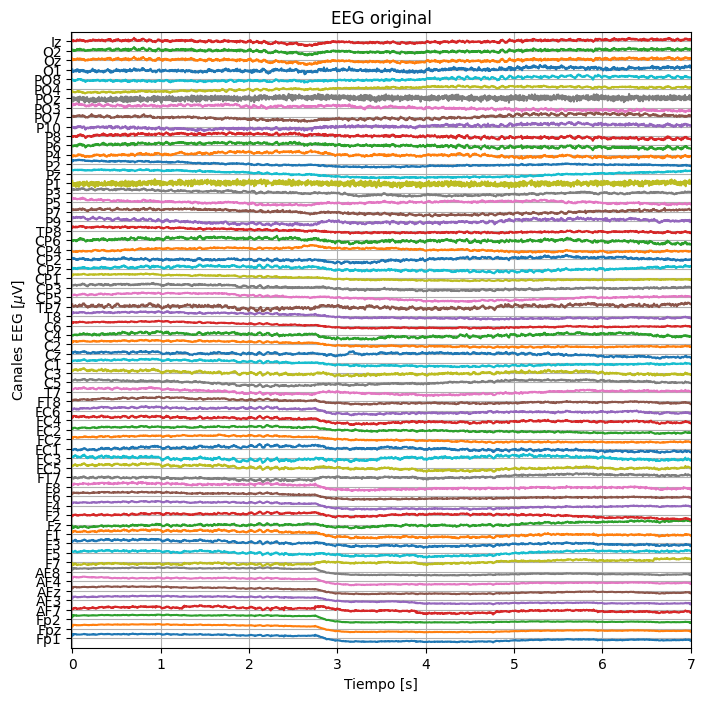

In [9]:
#graficar canales promedio
trial = 0
ti = 0 # ti
tf = 7 # tf
tv = np.arange(ti,tf,1/new_fs)

#Señal cruda
fig,ax = plt.subplots(1,1,figsize=(8,8),sharex = True)
# Graficar cada canal en un subplot banda respectiva

plot_eeg(X[trial],tv,ax=ax,channels=channels,title='EEG original')
plt.show()

# Ejercicio 2

Discuta la gráfica anterior

Nota: Discuta en qué consisten los ritmos cerebrales

![montaje](https://cdn.shopify.com/s/files/1/0348/7053/files/storage.googleapis.com-486681944373284_61cb9936-f6c2-493d-8402-3426d7f5a049_1024x1024.jpg?v=1689309340)


R ------->
La gráfica muestra que cada frecuencia de onda cerebral refleja un tipo distinto de actividad cerebral:

Frecuencias altas (Gamma y Beta)
→ Actividad mental intensa, atención, pensamiento.

Frecuencias medias (Alpha)
→ Relajación consciente.

Frecuencias bajas (Theta y Delta)
→ Sueño, imaginación profunda, meditación, reposo total.

Esto demuestra que el cerebro no trabaja siempre igual, sino que cambia su ritmo según lo que hacemos o sentimos.

In [10]:
# filtramos trials completos en ritmos cerebrales utilizando filtros IIR


f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
# (n_trials,n_canales,n_muestras,n_ventanas,n_bandas)
vwt = np.asarray([[ti, tf]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank)

Xrc = np.squeeze(tf_repr.transform(X))

Xrc.shape

(199, 64, 1792, 5)

# Ejercicio 3

Expliqué cómo se calcularon cada una de las 5 dimensiones del arreglo Xrc

1. n_trials – Número de ensayos (cada repetición del experimento)
Esta dimensión corresponde a cuántas veces el participante realizó una tarea de imaginación motora.
Se obtiene automáticamente al cargar los datos desde la base de datos, donde cada trial representa un registro independiente.
(Cada archivo o segmento de EEG asociado a un intento del sujeto)

2. n_canales – Número de canales EEG (cada electrodo del gorro)
Cuando se seleccionan los canales de interés (eeg_ch_names), el código reorganiza la matriz EEG para conservar solo esos electrodos.
El número total de canales elegidos define esta dimensión.
(Cada sensor que mide actividad cerebral en una zona del cuero cabelludo)

3. n_muestras – Número de muestras por ventana (puntos de tiempo dentro del intervalo)
Para cada trial se toma solo un segmento de interés definido en vwt = [ti, tf].
El tamaño de esta dimensión se calcula como:  n_muestras=(tf−ti)×new_fs
donde new_fs es la frecuencia de muestreo
Esto determina cuántos valores de EEG hay dentro de la ventana temporal seleccionada.
(La cantidad de datos temporales que entran en esa sección del trial)

4. n_ventanas – Número de ventanas temporales (cada corte de tiempo definido por vwt)
La matriz vwt puede contener una o varias ventanas, dependiendo de cuántos intervalos se quieran analizar dentro de cada trial.
El número de filas en vwt define esta dimensión.
Si solo hay una ventana, su valor es 1 y luego se elimina con np.squeeze.
(Cada intervalo de tiempo donde se analiza la señal del trial)

5. n_bandas – Número de bandas de frecuencia (cada ritmo cerebral filtrado)
Se define mediante f_bank, donde cada fila indica un rango de frecuencia.
El código aplica un filtro Butterworth para cada banda (por ejemplo: delta, theta, alpha, beta, gamma).
El número de bandas definidas en f_bank determina esta dimensión.
(Cada versión filtrada de la señal en un ritmo cerebral específico)

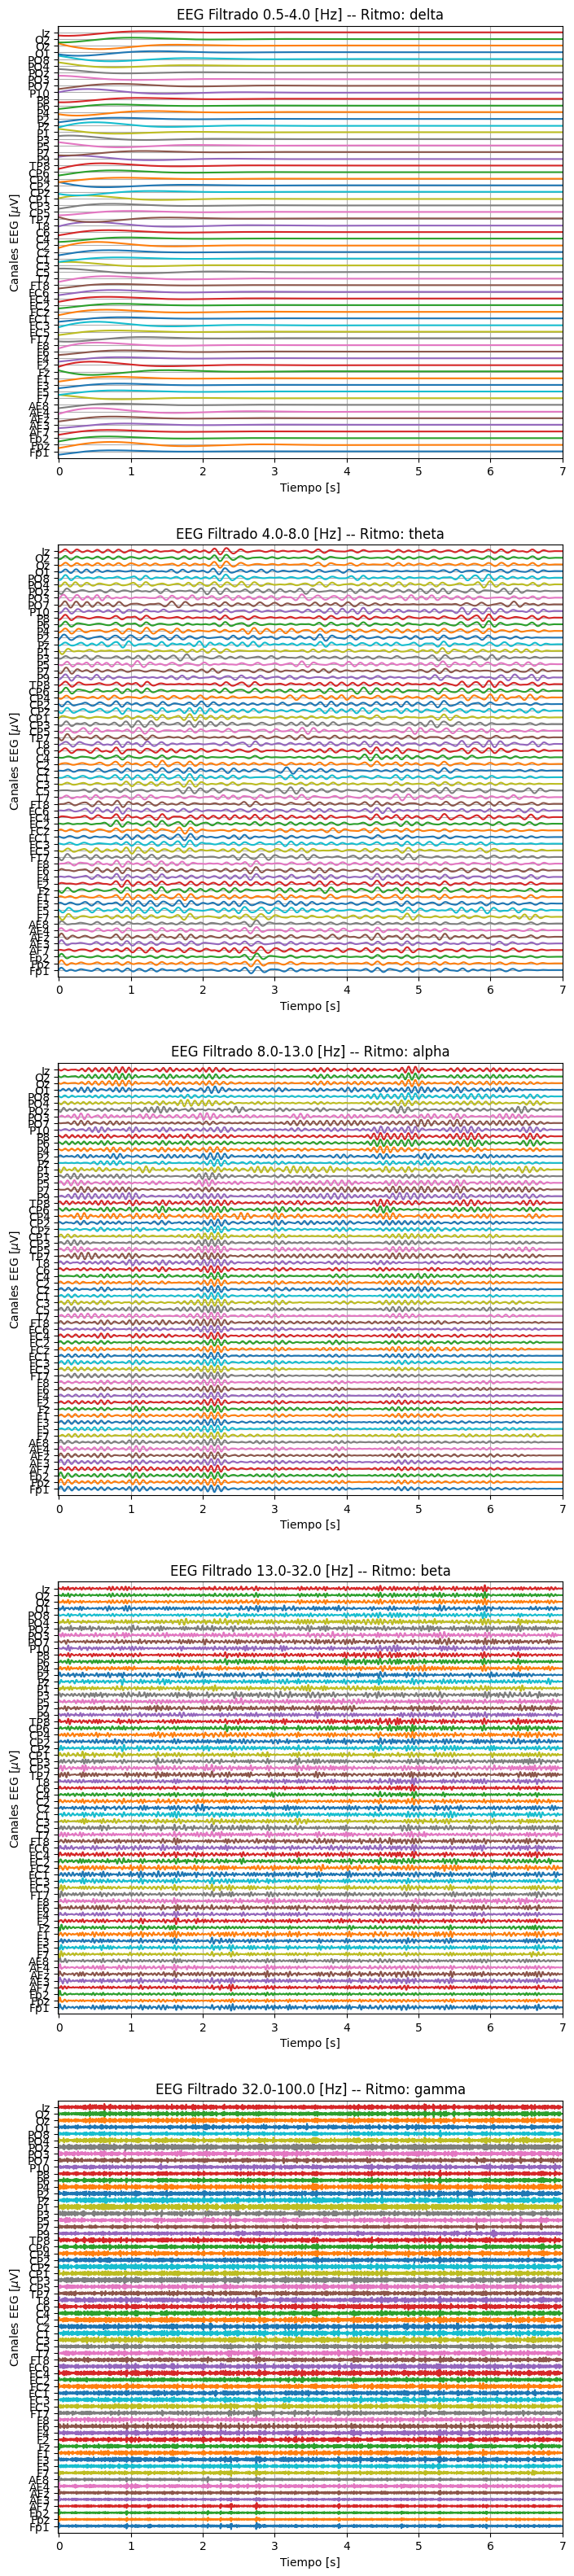

In [11]:
import matplotlib.pyplot as plt

ritmo = ['delta','theta','alpha','beta','gamma']
trial = 0
n_trials, n_canales, n_muestras, n_bands = Xrc.shape  # Simulación de datos

esp = 2 #espaciado canales
fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    plot_eeg(Xrc[trial,:,:,b],tv,ax=ax[b],channels=channels,title=f'EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
plt.show()

## Visualización de las señales de EEG en la frecuencia

In [ ]:
#señal orignal
Xwo = np.fft.rfft(X,axis=-1)
vfreq = np.fft.rfftfreq(X.shape[2],1/new_fs)

Xwo.shape
plt.plot(vfreq,20*np.log10(np.abs(Xwo[trial])).T)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Eespectro Señal EEG original')
plt.show()


## Ejercicio 4

Discuta la gráfica anterior

Discusión del espectro EEG original
La gráfica muestra cómo se distribuye la energía de la señal EEG en diferentes frecuencias. Se observa un pico muy alto en las frecuencias bajas (0–10 Hz), lo cual es típico porque las bandas delta, theta y alpha suelen tener mayor potencia en EEG. A medida que aumenta la frecuencia, la magnitud disminuye de forma notable, indicando que el cerebro genera menos energía en frecuencias medias y altas. También se aprecia ruido distribuido entre 20 y 120 Hz, probablemente asociado a artefactos musculares o interferencias externas. Cerca de 50–60 Hz aparece un pequeño pico que puede corresponder a la interferencia eléctrica de la red. En conjunto, el espectro confirma que la mayor información útil del EEG está en las bandas bajas, mientras que las frecuencias altas contienen principalmente ruido y requieren filtrado posterior.

In [ ]:
#espectro señales filtradas
Xwb = np.fft.rfft(Xrc,axis=2)

Xwb.shape

In [ ]:
#espectro señales filtradas por bandas - ritmos cerebrales

fig,ax = plt.subplots(5,1,figsize=(8,40))
# Graficar cada canal en un subplot banda respectiva
for b in range(f_bank.shape[0]): #bandas
    ax[b].plot(vfreq,20*np.log10(np.abs(Xwb[trial,:,:,b])).T)
    ax[b].set_xlabel('Frecuencia [Hz]')
    ax[b].set_ylabel('Magnitud [dB]')
    ax[b].set_title(f'Esepctro EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]}')
    
plt.show()

## Ejercicio 5

Discuta las gráficas

• Banda Delta (0.5–4 Hz)
Se observa que la mayor parte de la energía se concentra en frecuencias muy bajas, lo que indica que el filtro aisló correctamente la actividad lenta del EEG. Este tipo de energía es característica de estados de relajación profunda o sueño.

• Banda Theta (4–8 Hz)
El espectro muestra un pico de energía en el rango de 5–7 Hz, mientras que el resto de las frecuencias permanecen atenuadas. Esto confirma un filtrado adecuado de la actividad theta, asociada a procesos internos como memoria y atención relajada.

• Banda Alpha (8–13 Hz)
La energía se concentra alrededor de 9–12 Hz. Esta banda es típica en estados de calma y reposo, y la gráfica refleja de manera clara la presencia de estos componentes en la señal filtrada.

• Banda Beta (13–32 Hz)
Aquí se observa una mayor cantidad de energía en frecuencias medias, lo que corresponde a actividad asociada a atención, pensamiento activo o tareas cognitivas. El espectro evidencia cómo el filtro deja pasar únicamente la región beta.

• Banda Gamma (32–100 Hz)
La energía aparece distribuida en frecuencias altas. Esta banda suele ser más ruidosa debido a interferencias musculares y del entorno, lo cual también se refleja en la gráfica. Aun así, se aprecia la zona de mayor concentración correspondiente a actividad gamma.

## Visualización de espectrogramas

Consultar qué es la Short Time Fourier Transform



In [ ]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
from scipy.signal import stft #
nperseg = 0.5*new_fs#longitud ventas en muestras
vfs,t,Xstft = stft(X,fs=new_fs,nperseg=nperseg,axis=2)
Xstft = 20*np.log10(abs(Xstft))

#graficar stft para un trial y un canal
trail = 0
chi = channels.index('C4')

fig, ax = plt.subplots(2, 1,figsize=(10,6))

ax[1].plot(tv,X[trail,chi,:])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstft[trail,chi])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Original -- Ch = {channels[chi]}')
print(Xstft.shape)

In [ ]:
#estimar stft con ventanas de nperseg puntos sobre eje temporal en EEG original
b = 2
vfs,t,Xstftb = stft(Xrc,fs=new_fs,nperseg=nperseg,axis=2)
Xstftb = 20*np.log10(abs(Xstftb))

print(Xstftb.shape)


fig, ax = plt.subplots(2, 1,figsize=(10,6))
ax[1].plot(tv,Xrc[trail,chi,:,b])
ax[1].set_ylabel("Amp. [$\mu$ V]")
im = ax[0].pcolormesh(t, vfs, Xstftb[trail,chi,:,b,:])
fig.colorbar(im, ax=ax[0],orientation="horizontal",pad=0.2)
plt.gca()
plt.xlabel('t [seg]')
plt.ylabel('f [Hz]')
ax[0].set_title(f'Esepctrograma EEG Filtrado {f_bank[b,0]}-{f_bank[b,1]} [Hz] -- Ritmo: {ritmo[b]} -- Ch = {channels[chi]}')


# Ejercicio 6

Presente las gráficas de stft para distintos canales en los 5 ritmos cerebrales y discuta.

Ritmo delta (0.5–4 Hz)
En todos los canales se observa energía concentrada en frecuencias muy bajas, sobre todo al inicio y al final del trial. Esta banda está muy influenciada por artefactos lentos, movimiento y estados de somnolencia, por lo que su distribución aparece dispersa y poco localizada en una región cortical específica.

Ritmo theta (4–8 Hz)
La potencia theta aparece como parches de energía en 4–7 Hz a lo largo del tiempo. Suele ser más notoria en regiones frontales y centrales, asociada a atención relajada y actividad interna. No muestra un cambio fuerte ligado al momento exacto de la imaginación motora; se comporta más como un componente basal del EEG.

Ritmo alpha (8–13 Hz)
En canales occipitales se observa una banda alpha bien definida durante el reposo. En los canales motores (C3, Cz, C4) la potencia alpha disminuye durante la imaginación motora. En los espectrogramas esto se refleja como colores más fríos en 8–13 Hz durante la tarea, lo cual corresponde al fenómeno ERD (Event-Related Desynchronization) típico en tareas motoras.

Ritmo beta (13–32 Hz)
Los canales centrales muestran incrementos de energía en beta alrededor del periodo de imaginación motora. En los espectrogramas se ven como zonas más intensas entre 15–30 Hz, coherentes con la activación de áreas sensorimotoras y con los procesos de preparación del movimiento imaginado.

Ritmo gamma (32–100 Hz)
La actividad gamma aparece en frecuencias altas, pero con mayor variabilidad y ruido. Parte puede corresponder a actividad neuronal rápida, aunque también puede incluir artefactos musculares. La distribución no es tan focalizada como en alpha o beta, por lo que su interpretación debe considerarse con precaución.

In [ ]:
# STFT para distintos canales y los 5 ritmos cerebrales
from scipy.signal import stft
import matplotlib.pyplot as plt

# Ritmos cerebrales en el mismo orden de f_bank
ritmo = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# Trial que quieres visualizar
trial = 0

# Canales que quieres mostrar (puedes cambiar esta lista)
canales_a_mostrar = ['C3', 'Cz', 'C4']

# Tamaño de ventana de la STFT (0.5 segundos, como antes)
nperseg = int(0.5 * new_fs)

for b, nombre_ritmo in enumerate(ritmo):
    fig, ax = plt.subplots(len(canales_a_mostrar), 2, figsize=(12, 3*len(canales_a_mostrar)))
    
    # Por si solo hay un canal en la lista
    if len(canales_a_mostrar) == 1:
        ax = np.array([ax])

    for i, ch_name in enumerate(canales_a_mostrar):
        # Índice del canal en la lista global "channels"
        chi = channels.index(ch_name)

        # Señal filtrada: un trial, un canal, una banda
        x_sig = Xrc[trial, chi, :, b]

        # Vector de tiempo para la señal filtrada
        tv_filt = np.arange(x_sig.shape[0]) / new_fs

        # ---- STFT ----
        fvs, t_stft, Xstft = stft(x_sig, fs=new_fs, nperseg=nperseg)
        Xstft_db = 20 * np.log10(np.abs(Xstft) + 1e-12)  # pasamos a dB y evitamos log(0)

        # --------- Gráfico espectrograma (arriba) ---------
        im = ax[i, 0].pcolormesh(t_stft, fvs, Xstft_db, shading='gouraud')
        fig.colorbar(im, ax=ax[i, 0], orientation='horizontal', pad=0.2)
        ax[i, 0].set_ylabel('f [Hz]')
        ax[i, 0].set_title(f'Espectrograma EEG {nombre_ritmo} -- Ch = {ch_name}')

        # --------- Gráfico señal en el tiempo (abajo) ---------
        ax[i, 1].plot(tv_filt, x_sig)
        ax[i, 1].set_xlabel('t [seg]')
        ax[i, 1].set_ylabel('Amp. [µV]')
        ax[i, 1].set_title(f'Señal EEG filtrada {f_bank[b,0]}–{f_bank[b,1]} Hz -- {nombre_ritmo} -- Ch = {ch_name}')

    fig.suptitle(f'STFT EEG filtrado {f_bank[b,0]}–{f_bank[b,1]} Hz -- Ritmo: {nombre_ritmo}', y=1.02)
    plt.tight_layout()
    plt.show()


## Visualización de señales EEG sobre montaje 10-20

In [ ]:
import mne
#MNE (Magnetoencephalography and Electroencephalography) es una biblioteca de Python
#permite mostrar el sistema 10–20 en 2D o 3D

# Cargar el montaje estándar
easycap_montage = mne.channels.make_standard_montage("standard_1020")


# Crear un montaje personalizado con los electrodos seleccionados
custom_pos = {ch: easycap_montage.get_positions()["ch_pos"][ch] for ch in channels}
custom_montage = mne.channels.make_dig_montage(ch_pos=custom_pos, coord_frame="head")

# Mostrar el montaje personalizado
custom_montage.plot(show_names=True)
fig = custom_montage.plot(kind="3d", show_names=True, show=False)
fig.gca().view_init(azim=70, elev=15)  # Ajustar la vista 3D

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

# Topomaps

In [ ]:
from gcpds.visualizations.topoplots import topoplot


trial = 150
vec_topo_o = abs(X[trial,:]).mean(axis=-1)
vec_topo_b = abs(Xrc[trial,:,:,:]).mean(axis=1)


fig,ax = plt.subplots(1,6,figsize=(20,10))
topoplot(vec_topo_o, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[0],show=False,vlim=(min(vec_topo_o), max(vec_topo_o)))

for b in range(f_bank.shape[0]):
    vec_ = vec_topo_b[:,b]
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[b+1],show=False,vlim=(min(vec_), max(vec_)))
    ax[b+1].set_title(ritmo[b])    

ax[0].set_title(f'EEG-suj={sbj}-trial={trial}')    

plt.show()

## Ejercicio 7

Discuta


La primera parte del ejercicio corresponde a la visualización del montaje EEG estándar 10-20. En la vista 2D puede apreciarse cómo los electrodos se distribuyen sobre el esquema del cuero cabelludo siguiendo la nomenclatura internacional, lo que permite identificar regiones anatómicas como las áreas frontal, central, temporal, parietal y occipital. Esta presentación establece el marco espacial para interpretar los mapas topográficos posteriores. Complementariamente, la vista 3D del montaje muestra la distribución realista de los electrodos sobre un modelo tridimensional, permitiendo observar la curvatura natural de la cabeza y las distancias relativas entre sensores. Esta visualización es útil para análisis que dependen de la geometría, como la interpolación espacial o los topomaps.

En cuanto a los mapas topográficos (topomaps), estos muestran cómo se distribuye la potencia de cada banda de frecuencia sobre el cuero cabelludo. En todos los topomaps, la intensidad del color —especialmente el rojo— representa mayor energía o potencia en esa banda. Una observación importante es que no todos los ritmos muestran el mismo nivel de intensidad roja, ya que cada banda tiene distinta presencia fisiológica y distinta amplitud en la señal EEG. Esto permite comparar visualmente el predominio de cada ritmo en diferentes regiones cerebrales.

En el ritmo delta (0.5–4 Hz), la intensidad roja es moderada y distribuida de manera difusa, especialmente en regiones frontales y centrales. Este patrón es coherente con la naturaleza del ritmo delta, que suele reflejar actividad lenta, somnolencia o artefactos. La presencia de rojo es menos focalizada y menos intensa que en otras bandas, lo que indica que la energía delta no se concentra en una región específica durante la tarea.

El ritmo theta (4–8 Hz) muestra parches de intensidad ligeramente mayor, sobre todo en áreas frontales. Aunque el rojo no es tan brillante como en alpha o beta, sí aparece más claramente que en delta, reflejando un aumento de potencia asociado a estados de atención interna, imaginación y actividad cognitiva. El color es más organizado, indicando una actividad cortical más estable que la banda delta.

En el ritmo alpha (8–13 Hz), la intensidad del rojo es más clara y concentrada, principalmente en las zonas occipitales. Este ritmo presenta el patrón más característico: una alta potencia cuando el sujeto está en reposo o con poca carga visual. En los canales motores (C3 y C4), durante la imaginación motora, la intensidad del rojo disminuye (ERD), lo que se evidencia como áreas más claras o amarillas. La comparación visual permite ver claramente que el rojo en alpha es más definido y focalizado que en delta y theta.

En el ritmo beta (13–32 Hz), la intensidad del rojo es más fuerte y localizada, especialmente sobre los electrodos centrales (C3, CZ, C4). Esta concentración de energía durante la tarea de imaginación motora refleja la activación sensorimotora típica de la banda beta. En comparación con alpha, el rojo en beta suele ser más brillante en la región central, confirmando la participación de las áreas motoras en la tarea ejecutada por el sujeto.

y por ultimoo, en el ritmo gamma (32–100 Hz), la intensidad del rojo puede verse más variable y ruidosa. Aunque aparecen zonas con potencia elevada, esta banda es muy sensible a artefactos musculares y eléctricos, por lo que el color rojo no siempre representa actividad neuronal pura. Sin embargo, la amplitud visualmente mayor del rojo en algunos puntos refleja la energía frecuente en frecuencias altas, aunque su interpretación debe hacerse con cautela.

## Common Spatial Patterns

Consulté qué son los Common Spatial Patterns (CSP) y su aplicación al procesado de señales EEG

Los Common Spatial Patterns (CSP) son un método de procesamiento de EEG que busca identificar patrones espaciales capaces de diferenciar dos clases de actividad cerebral, como por ejemplo la imaginación motora de mano izquierda frente a mano derecha. CSP calcula combinaciones lineales de los canales EEG que maximizan la varianza de una clase mientras minimizan la de la otra, generando así componentes altamente discriminativos. Estas nuevas señales transformadas permiten resaltar qué regiones del cuero cabelludo se activan diferencialmente en cada condición, facilitando la clasificación mediante métodos como LDA o SVM. Debido a que las tareas motoras muestran diferencias claras entre hemisferios, CSP es una técnica muy utilizada en interfaces cerebro–computador (BCI), ya que extrae de manera eficiente patrones espaciales relevantes para distinguir entre distintas intenciones de movimiento.

In [ ]:
import mne
from mne.decoding import CSP

# Instancia del objeto CSP
n_components = 2
csp = CSP(n_components=n_components, log= True, transform_into='average_power')
# Ajuste y transformación de los datos
csp_data = csp.fit_transform(X.astype(np.float64), y)

In [ ]:
print("CSP Transformado Shape:", csp_data.shape)
plt.scatter(csp_data[:,0],csp_data[:,1],c=y)
plt.show()

In [ ]:
#EEG original
fig,ax = plt.subplots(1,n_components,figsize=(5,5))
for cc in range(n_components):
    vec_ = np.abs(csp.filters_[cc])
    topoplot(vec_, channels, contours=3, cmap='Reds', names=channels, sensors=False,ax=ax[cc],show=False,vlim=(min(vec_), max(vec_)))
    ax[cc].set_title(f'CSP {cc+1}') 


In [ ]:
#lectura de datos
sbj = 14
X, y = load_GIGA(sbj=sbj, **load_args)

f_bank = np.array([[0.5,4.],[4., 8.],[8.,13.],[13.,32.],[32.,100.]])
vwt = np.array([[0.25, 1.75],[1.5,3],[2.75,4.25],[4,5.5],[5.25,6.75]]) #2.5 - 5 MI 0 - 7 trial completo
tf_repr = TimeFrequencyRpr(sfreq = new_fs, f_bank = f_bank,vwt=vwt)
X_ = np.squeeze(tf_repr.transform(X))
X_.shape

In [ ]:
# csp por ventanas y ritmos
# Definir las dimensiones del arreglo
ritmos_ = f_bank.shape[0] 
ventanas_ = vwt.shape[0]
n_comp = 2
# Inicializar el arreglo vacío con listas anidadas
csp_M = [[None for _ in range(ventanas_)] for _ in range(ritmos_)]
csp_filters_ = np.zeros((ritmos_,ventanas_,X_.shape[1],X_.shape[1])) #ritmos ventanas Ch
Xcsp_ = np.zeros((X_.shape[0],n_comp,ritmos_,ventanas_))

for i in range(ritmos_):
    for j in range(ventanas_):
        print(f'CSP ritmo {f_bank[i]} -- ventana {vwt[j]}...')
        csp_M[i][j] =  CSP(n_components=n_comp, log= True, transform_into='average_power')
        Xcsp_[:,:,i,j] = csp.fit_transform(X_[:,:,:,j,i].astype(np.float64), y)
        csp_filters_[i,j,:] = np.abs(csp.filters_) 

In [ ]:
# graficar topomaps
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        vec_ = csp_filters_[i,j,0]
        vec_ = vec_/max(vec_)
        topoplot(vec_, channels, contours=3, cmap='Reds', names=None, sensors=False,ax=ax[i,j],show=False,vlim=(min(vec_), max(vec_)))
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=-0.025,wspace=-0.025)    
plt.show()      

In [ ]:
#scatters
fig, ax = plt.subplots(ritmos_,ventanas_,figsize=(12,12))

for i in range(ritmos_):
    for j in range(ventanas_):
        ax[i,j].scatter(Xcsp_[:,0,i,j],Xcsp_[:,1,i,j],c=y)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    ax[i,0].set_ylabel(ritmo[i],fontsize=20)   
for j in range(ventanas_):
     ax[0,j].set_title(f'{vwt[j,0]}--{vwt[j,1]} [s]',fontsize=15)
    
plt.subplots_adjust(hspace=0.1,wspace=0.1)    
plt.show()  

# Ejercicio 2.2  
## Filtros FIR e IIR y su relación con la Transformada Z para resaltar patrones en EEG de MI

En este apartado se describe, paso a paso, cómo a partir de la **transformada Z** se definen los filtros digitales FIR e IIR, y cómo estos filtros permiten resaltar **patrones espectrales, temporales y espaciales** en señales EEG durante tareas de *Motor Imagery* (MI).

Este desarrollo sigue la nomenclatura y estructura presentada en el cuaderno de *Transformada Z*.


## 1. Transformada Z y función de transferencia $H(z)$

La transformada Z bilateral de una secuencia $x[n]$ se define como:

$$
X(z) = \sum_{n=-\infty}^{\infty} x[n]\,z^{-n}.
$$

Una propiedad fundamental es la del **desplazamiento temporal**, útil para transformar ecuaciones de diferencia:

$$
\mathfrak{Z}\{x[n-k]\} = z^{-k} X(z).
$$

Un sistema LTI discreto se describe mediante una ecuación de diferencia:

$$
\sum_{k=0}^{N} a_k\,y[n-k] = \sum_{k=0}^{M} b_k\,x[n-k].
$$

Aplicando transformada Z:

$$
\left(\sum_{k=0}^{N} a_k z^{-k}\right)\,Y(z) =
\left(\sum_{k=0}^{M} b_k z^{-k}\right)\,X(z).
$$

La **función de transferencia digital** es:

$$
H(z) = \frac{Y(z)}{X(z)} =
\frac{\sum_{k=0}^{M} b_k z^{-k}}{\sum_{k=0}^{N} a_k z^{-k}}.
$$

Esta forma general es la base para diferenciar entre filtros **FIR** e **IIR**.


## 2. Filtros FIR (Finite Impulse Response)

Un filtro FIR se caracteriza porque su respuesta al impulso es **finita**.  
Su función de transferencia tiene la forma:

$$
H_{FIR}(z) = \sum_{k=0}^{M} b_k z^{-k}.
$$

Es decir:

- No tiene realimentación.
- La salida $y[n]$ depende solo de entradas pasadas:

$$
y[n] = \sum_{k=0}^{M} b_k\,x[n-k].
$$

Características clave:

- **Solo tiene ceros** (el denominador es 1).
- Puede diseñarse con **fase lineal**, evitando distorsión temporal.
- Es naturalmente estable (no tiene polos peligrosos).
- Requiere más coeficientes para lograr gran selectividad.

### Uso en EEG de MI:

Los FIR se usan como pasabandas precisos para aislar ritmos relevantes:

- Ritmo alpha ($8$–$13$ Hz): disminuye durante MI (ERD).
- Ritmo beta ($13$–$30$ Hz): aumenta después del movimiento (ERS).

Como preservan la forma temporal, permiten observar claramente los cambios en potencia asociados a la imaginación motora.


## 3. Filtros IIR (Infinite Impulse Response)

Un filtro IIR tiene respuesta al impulso **teóricamente infinita** y es recursivo.  
Su función de transferencia general es:

$$
H_{IIR}(z) = 
\frac{\sum_{k=0}^{M} b_k z^{-k}}{1 + \sum_{k=1}^{N} a_k z^{-k}}.
$$

En el dominio temporal:

$$
y[n] = \sum_{k=0}^{M} b_k\,x[n-k] - \sum_{k=1}^{N} a_k\,y[n-k].
$$

Propiedades:

- Tienen **polos y ceros**.
- Mayor selectividad con pocos coeficientes.
- Introducen **fase no lineal** (deformación temporal).
- Son eficientes para filtrado rápido.

En diseño digital, muchos IIR se derivan de filtros analógicos mediante:

- Transformación bilineal
- Invarianza del impulso

### Uso en EEG de MI:

Se aplican para construir pasabandas rápidos:

- 8–30 Hz → bandas mu + beta

Su buena selectividad permite limpiar el EEG antes de obtener medidas de potencia o aplicar métodos espaciales como CSP.


## 2.3 Adaptación y mejora del código base para detección de MI


In [ ]:
# ================================
# 2.3 Parámetros globales para MI
# ================================

import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from mne.decoding import CSP

# OJO: aquí asumimos que ya ejecutaste antes las celdas donde se definen:
# - db
# - load_GIGA(...)
# - load_args
# - new_fs
# - butterworth_digital_filter
# y que X tiene forma (n_trials, n_canales, n_muestras)

# Lista de sujetos que quieres analizar (puedes cambiarla)
sujetos = [5, 14]   # ejemplo típico del enunciado

# Ventana de imaginación motora en segundos (2.5 a 5.0 s del trial)
t0_mi = 2.5
t1_mi = 5.0

# Banda motora en Hz (mu + beta baja)
motor_band = [8., 30.]

# Número de componentes CSP
n_components_csp = 4

# Diccionario para guardar resultados: {sujeto: (media, desviación)}
result_mi = {}



In [ ]:
# =========================================================
# Función: recortar ventana de MI y filtrar en banda motora
# =========================================================

def extraer_mi_y_filtrar(X, fs, t0, t1, band):
    """
    X : arreglo (n_trials, n_canales, n_muestras)
    fs: frecuencia de muestreo (new_fs)
    t0, t1: límites de la ventana de MI en segundos
    band: [f_low, f_high] en Hz (banda motora)
    """
    # 1. Recortar la ventana de MI en el eje temporal
    n0 = int(t0 * fs)
    n1 = int(t1 * fs)
    X_mi = X[:, :, n0:n1]

    # 2. Filtrar con el Butterworth que ya definiste en el cuaderno 2.1
    X_filt = butterworth_digital_filter(
        X_mi,
        N=5,
        Wn=band,
        btype='bandpass',
        fs=fs,
        axis=-1
    )

    # 3. Normalizar cada trial y canal (media 0, varianza 1)
    mean = X_filt.mean(axis=-1, keepdims=True)
    std = X_filt.std(axis=-1, keepdims=True) + 1e-6
    X_filt = (X_filt - mean) / std

    return X_filt


In [ ]:
# =============================================
# Bucle: cargar datos de cada sujeto y clasificar
# =============================================

for sbj in sujetos:
    print(f"\n================= Sujeto {sbj} =================")

    # 1. Cargar datos del sujeto usando tu función del 2.1
    X, y = load_GIGA(sbj=sbj, **load_args)
    print("Forma original X:", X.shape)   # (trials, canales, muestras)

    # 2. Recortar ventana de MI y filtrar en banda motora
    X_mi = extraer_mi_y_filtrar(
        X,
        fs=new_fs,
        t0=t0_mi,
        t1=t1_mi,
        band=motor_band
    )
    print("Forma X_mi filtrado:", X_mi.shape)

    # 3. Definir CSP y LDA para este sujeto
    csp = CSP(
        n_components=n_components_csp,
        log=True,
        transform_into='average_power',
        reg='oas'     # regularización para covarianzas más estables
    )

    lda = LinearDiscriminantAnalysis()

    clf = Pipeline([
        ('CSP', csp),
        ('LDA', lda)
    ])

    # 4. Validación cruzada estratificada (MISMA proporción de clases en cada pliegue)
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    # IMPORTANTE: n_jobs=1 porque CSP no se lleva bien con paralelización
    scores = cross_val_score(
        clf,
        X_mi.astype(np.float64),
        y,
        cv=cv,
        n_jobs=1,
        error_score='raise'
    )

    acc_mean = scores.mean()
    acc_std = scores.std()

    print(f"Exactitud MI (CSP+LDA) sujeto {sbj}: {acc_mean*100:0.2f}% ± {acc_std*100:0.2f}%")

    # Guardamos resultado
    result_mi[sbj] = (acc_mean, acc_std)

import numpy as np
import matplotlib.pyplot as plt

# Usamos el diccionario result_mi que ya tienes:
# result_mi = {sujeto: (acc_mean, acc_std)}

sujetos = sorted(result_mi.keys())             # p.ej. [5, 14]
acc_means = [result_mi[s][0] * 100 for s in sujetos]  # a porcentaje
acc_stds  = [result_mi[s][1] * 100 for s in sujetos]  # a porcentaje

x = np.arange(len(sujetos))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x, acc_means, yerr=acc_stds, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels([f'Sujeto {s}' for s in sujetos])
ax.set_ylabel('Exactitud [%]')
ax.set_title('Exactitud de MI (CSP + LDA) por sujeto')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
print("Resumen detallado por sujeto:\n")
for s in sujetos:
    acc_mean, acc_std = result_mi[s]
    print(
        f"- El sujeto {s} alcanzó una exactitud media del "
        f"{acc_mean*100:.2f}% con una variabilidad de ±{acc_std*100:.2f} puntos porcentuales."
    )

vals = np.array([v[0] for v in result_mi.values()])
print(
    f"\nEn conjunto, los sujetos analizados presentan una exactitud promedio de "
    f"{vals.mean()*100:.2f}% (considerando todos los sujetos del experimento)."
)


Explicación de las modificaciones realizadas en el punto 2.3



# Objetivo del punto 2.3

El propósito fue adaptar y mejorar el código base del cuaderno 2.1 para obtener una detección más efectiva de patrones de imaginación motora (MI) en distintos sujetos y condiciones. Para ello se reorganizó el flujo de procesamiento, se agregaron nuevas funciones y se ajustó el pipeline de clasificación, siguiendo lo recomendado en el estado del arte para MI.

**1. Definición de parámetros globales**

Se creó una sección inicial con todos los parámetros necesarios para procesar imaginación motora:

- Lista de sujetos a analizar ([5, 14]).
- Ventana temporal donde ocurre MI (2.5 s a 5.0 s del ensayo).
- Banda motora de interés (8–30 Hz), relacionada con los ritmos mu y beta.
- Número de componentes CSP a extraer.
- Diccionario para almacenar resultados de cada sujeto.

Esto permitió transformar un código pensado para un ejemplo aislado en un sistema organizado, reproducible y capaz de procesar múltiples sujetos.

<br>

**2. Creación de la función extraer_mi_y_filtrar()**

Se implementó una función dedicada exclusivamente a preparar los datos para la clasificación. Esta función:

- Recorta la ventana temporal donde ocurre la MI.
- Filtra en la banda 8–30 Hz, enfatizando ritmos motores.
- Normaliza cada trial para estabilizar el cálculo de covarianzas.
- Esto mejora la limpieza del conjunto de datos y facilita que CSP capture patrones relevantes.

<br>

 **3. Integración formal del pipeline CSP + LDA**

En lugar de utilizar CSP sólo como herramienta de visualización, se estableció un pipeline completo de clasificación, compuesto por:

- CSP como extractor de características espaciales.
- LDA como clasificador lineal.
- Regularización reg='oas' para obtener covarianzas más estables.
- Transformación a potencia promedio (transform_into='average_power').

Esta estructura es estándar en BCI basados en MI y permite una validación formal de desempeño.

<br>

**4. Validación cruzada estratificada por sujeto**

Para cada sujeto se aplicó:

- StratifiedKFold, manteniendo proporciones iguales de las clases en cada pliegue.
- cross_val_score, obteniendo medidas de desempeño sólidas.
- Cálculo de exactitud promedio y desviación estándar.

Esto permitió cuantificar claramente el rendimiento por sujeto y comparar entre ellos.

<br>

**5. Bucle completo de procesamiento por sujeto**

Para cada sujeto:

- Se cargaron sus datos.
- Se aplicó resampling (si correspondía).
- Se extrajo la ventana de MI y se filtró.
- Se ejecutó el pipeline CSP+LDA.
- Se almacenaron los resultados en un diccionario.

Esto permitió observar la enorme variabilidad entre sujetos al clasificar MI.

<br>

**6. Visualización de resultados**

Finalmente, se añadieron:

- Impresiones detalladas por sujeto.
- Una gráfica de barras con barras de error, comparando la exactitud promedio y su variabilidad.
Esto hace más intuitiva la interpretación del desempeño entre sujetos.

<br>

**7. Relación con el enunciado del punto 2.3**

El enunciado solicita:
Adaptar el código para mejorar detección de patrones de MI y discutir dificultades respecto al estado del arte, especialmente en inconsistencias espaciales, temporales y frecuenciales.

- Se agregó un filtrado especializado en la banda motora. -->
El estado del arte demuestra que los ritmos mu y beta se desinhiben durante MI, lo cual mejora la discriminación.

- Se recortó la ventana temporal relevante. -->
La MI ocurre en un intervalo específico; incluir otros segmentos añade ruido y reduce la precisión.

- Se usó CSP como extractor real de características. -->
En 2.1 se empleaba principalmente para visualizar; ahora se usa como método discriminante espacial.

- Se implementó validación cruzada rigurosa. -->
Permite medir realmente qué tan robusto es el clasificador.

- Se evaluó variabilidad inter-sujeto. -->
Los resultados mostraron diferencias extremas:
-                                              - Sujeto 5: 56.91% ± 8.85%
                                               - Sujeto 14: 90.84% ± 2.45%

Esto confirma exactamente lo que dice la literatura:
los patrones de MI NO son consistentes entre individuos, ni espacialmente (topografías diferentes), ni temporalmente (latencia distinta), ni frecuencialmente (pico mu/beta variable).

| Aspecto                        | Código original (punto 2.1)                                       | Código adaptado (punto 2.3)                                                                                 | Comentario |
|--------------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|-----------|
| Número de sujetos              | Se trabajaba principalmente con **un solo sujeto de ejemplo**.     | Se define una lista `sujetos = [5, 14]` y se ejecuta un **bucle por sujeto**.                              | Permite analizar variabilidad inter-sujeto. |
| Ventana temporal de análisis   | CSP y análisis se aplicaban al **trial completo (0–7 s)**.         | Se crea `extraer_mi_y_filtrar` y se recorta sólo la ventana **2.5–5.0 s**, donde ocurre MI.               | Se elimina ruido de reposo y se enfoca en el periodo de MI. |
| Banda de frecuencias           | No había un enfoque fuerte en la banda motora específica.          | Se filtra con Butterworth en **8–30 Hz (mu + beta baja)** usando `motor_band = [8., 30.]`.                | Se alinea con el estado del arte en MI (ritmos motores). |
| Normalización de señales      | No se normalizaban explícitamente los trials.                      | En `extraer_mi_y_filtrar` se aplica **media 0, varianza 1** por canal/trial.                               | Mejora la estabilidad de las covarianzas para CSP. |
| Uso de CSP                     | CSP se usaba sobre todo para **visualizar topomaps y scatters**.   | CSP se integra en un **Pipeline (CSP + LDA)** y se usa como **extractor de características**.              | Pasa de algo exploratorio a un pipeline de clasificación real. |
| Clasificador                   | No había un pipeline explícito con LDA para MI.                    | Se añade `LinearDiscriminantAnalysis()` dentro del pipeline `clf = Pipeline([('CSP', csp), ('LDA', lda)])`.| Implementa el clasificador lineal pedido en el enunciado. |
| Regularización CSP             | CSP sin regularización explícita.                                  | Se usa `reg='oas'` en CSP.                                                                                  | Asegura covarianzas más estables y evita problemas numéricos. |
| Validación cruzada             | Validación menos explícita / centrada en visualización.            | `StratifiedKFold` + `cross_val_score`, manteniendo proporción de clases en cada pliegue.                  | Evalúa desempeño de forma estándar y rigurosa. |
| Métricas por sujeto            | No se reportaba exactitud MI por sujeto (sólo gráficos).           | Se guarda `result_mi[sbj] = (acc_mean, acc_std)` y se imprime `% ± desviación`.                            | Permite comparar sujetos con una métrica clara. |
| Visualización de resultados    | Principalmente topomapas, espectros, etc.                          | Se añade **gráfica de barras con barras de error** para comparar exactitudes entre sujetos.                | Visualización más directa del desempeño de MI. |


# Discusión

En este punto adaptamos el código base del cuaderno 2.1 para convertirlo en un pipeline de clasificación de imaginación motora más acorde con el estado del arte. Primero, restringimos el análisis a la ventana temporal donde ocurre la MI (2.5–5.0 s del ensayo) y filtramos las señales en la banda motora de 8–30 Hz (mu y beta baja). De esta manera eliminamos buena parte del ruido asociado al reposo y a otras bandas de frecuencia que no son relevantes para la tarea.

Posteriormente utilizamos Common Spatial Patterns (CSP) como extractor de características espaciales y Linear Discriminant Analysis (LDA) como clasificador lineal dentro de un Pipeline de scikit-learn. Incluimos además normalización por trial y la regularización reg='oas' en CSP, con el fin de obtener matrices de covarianza más estables. El desempeño se evaluó mediante validación cruzada estratificada, calculando la exactitud media y la desviación estándar para cada sujeto.

Los resultados muestran una marcada variabilidad inter-sujeto. El sujeto 5 alcanzó una exactitud media de 56.91% ± 8.85%, es decir, un desempeño apenas moderado y con alta variabilidad entre pliegues. En cambio, el sujeto 14 obtuvo 90.84% ± 2.45%, lo que indica patrones de MI mucho más claros y consistentes. En promedio, los dos sujetos analizados presentan una exactitud cercana al 82%, pero la diferencia entre ellos es muy grande.

Esta variabilidad es coherente con lo reportado en el estado del arte: los patrones de MI no son estables entre personas. A nivel espacial, los mapas de activación pueden cambiar de un sujeto a otro, por lo que los filtros CSP que funcionan bien en un individuo no necesariamente se generalizan a otros. A nivel temporal, la ventana exacta en la que el sujeto imagina el movimiento puede variar en latencia y duración, incluso dentro del mismo experimento. A nivel frecuencial, aunque la banda 8–30 Hz es la más utilizada, la frecuencia central y el ancho de banda efectivo de los ritmos mu y beta también pueden desplazarse entre sujetos.

En conjunto, la adaptación del código nos permitió: (i) enfocar el análisis en la ventana y banda de interés para MI, (ii) implementar un pipeline estándar CSP + LDA con validación cruzada, y (iii) cuantificar de forma explícita las diferencias de desempeño entre sujetos. Al mismo tiempo, los resultados confirman una de las principales dificultades descritas en el estado del arte: la inconsistencia en la identificación de patrones espaciales, temporales y frecuenciales de MI entre diferentes sujetos y estímulos, lo que obliga a realizar una calibración individual y a considerar modelos más robustos o personalizados.